In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Viewing information about the training data values first
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


In [3]:
# Separating numeric and categorical variables for histogram / value count visualizations
numeric_var = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categoric_var = ["PassengerId", "HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP", "Transported"]

# We ignore name because they likely unique and not related to the analysis.

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


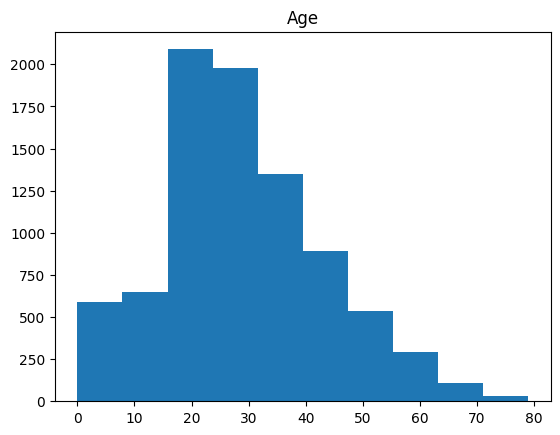

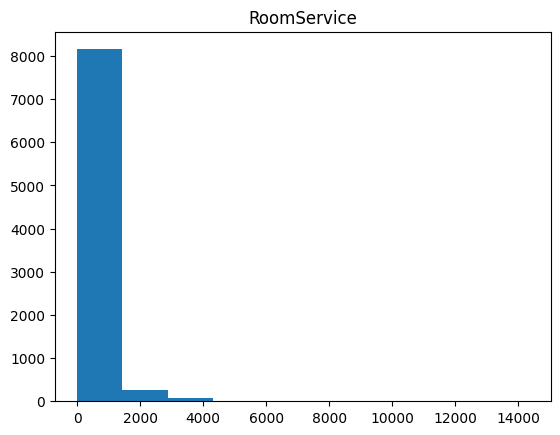

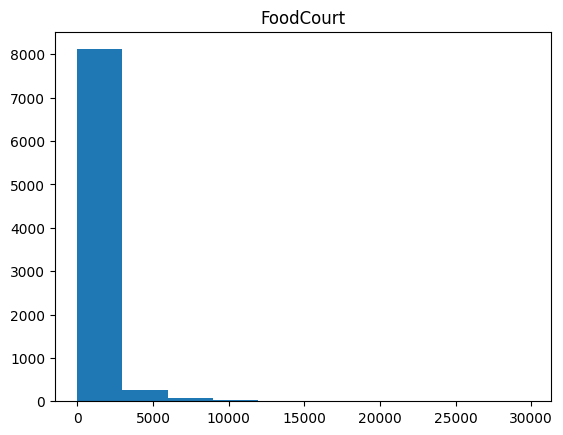

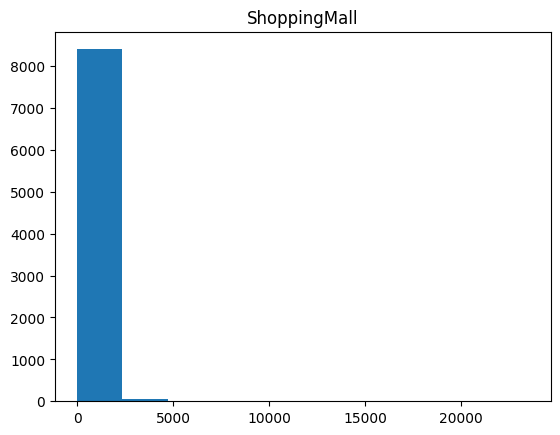

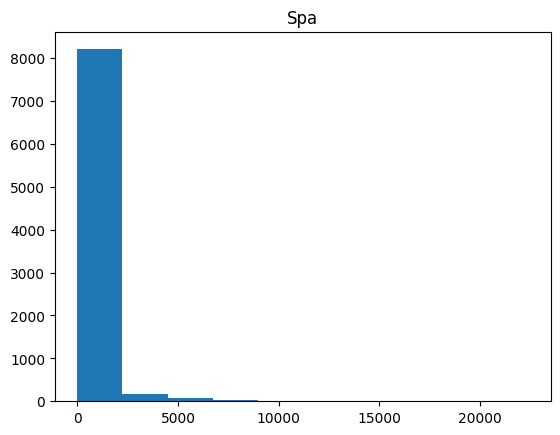

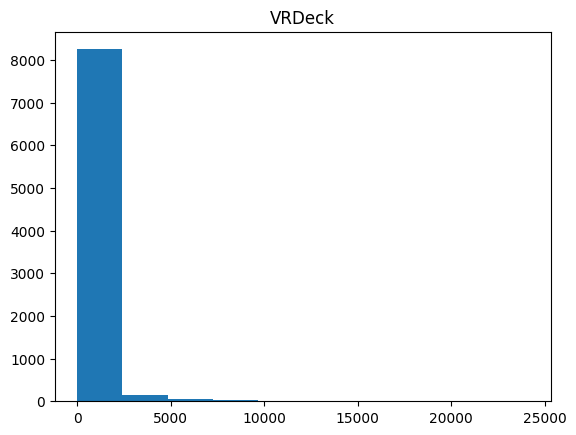

In [4]:
# Creating histograms for the numeric variables to understand their distributions
for var in numeric_var:
    plt.hist(train_df[var])
    plt.title(var)
    plt.show()

# Analysis of numerical columns
* Looking at the description of Room Service, Shopping Mall, Spa, and VRDeck, we see that they are all amounts of spending. Based on that information, it makes sense to perhaps add them into a total score that models how spendy (and likely how wealthy) a certain passenger is.
* We can call this new column wealth, as express it as a sum of those other numeric columns

In [5]:
wealth = train_df["RoomService"] + train_df["FoodCourt"] + train_df["ShoppingMall"] + train_df["Spa"] + train_df["VRDeck"]
train_df.insert(0, "Wealth", wealth)
train_df.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1, inplace=True)

/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


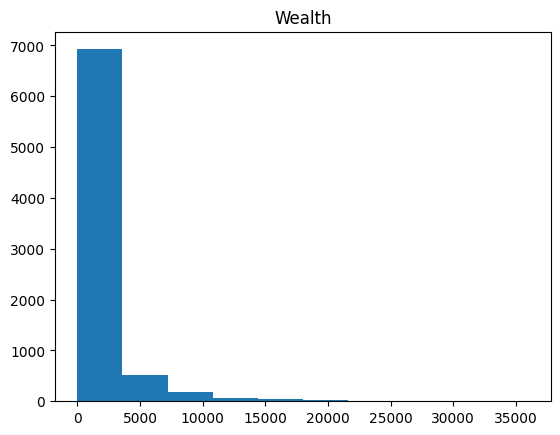

In [6]:
plt.hist(train_df["Wealth"])
plt.title("Wealth")
plt.show()

In [7]:
# Dropping name from the train_df because it is not useful
train_df.drop("Name", axis=1, inplace=True)
print(train_df.head())

    Wealth PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0      0.0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1    736.0     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2  10383.0     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3   5176.0     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4   1091.0     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  


In [8]:
# Visualizing the categorical variables with value counts
for var in categoric_var:
    print(f"Value counts for {var}: {train_df[var].value_counts()}")

Value counts for PassengerId: PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64
Value counts for HomePlanet: HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
Value counts for CryoSleep: CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Value counts for Cabin: Cabin
G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: count, Length: 6560, dtype: int64
Value counts for Destination: Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
Value counts for VIP: VIP
False    8291
True      199
Name: count, dtype: int64
Value counts for Transported: Transported
True     4378
False    4315
Name: count, dtype: int64


# Analysis of the value counts for the categorical variables
* It seems like the Destination, VIP, HomePlanet, and CryoSleep variables are all well defined as is
* The Cabin variable seems the most interesting, and it may be helpful to generate two additional variables: Side and Deck that have more representation in the value counts. I believe the current categorical variable doens't have that much of an impact on the final score

In [9]:
deck = [str(train_df["Cabin"][i]).split('/')[0] for i in range(len(train_df))]
side = [str(train_df["Cabin"][i]).split('/')[-1] for i in range(len(train_df))]
train_df.insert(0, "Deck", deck)
train_df.insert(0, "Side", side)
train_df.drop("Cabin", axis=1, inplace=True)
print(train_df.head())

  Side Deck   Wealth PassengerId HomePlanet CryoSleep  Destination   Age  \
0    P    B      0.0     0001_01     Europa     False  TRAPPIST-1e  39.0   
1    S    F    736.0     0002_01      Earth     False  TRAPPIST-1e  24.0   
2    S    A  10383.0     0003_01     Europa     False  TRAPPIST-1e  58.0   
3    S    A   5176.0     0003_02     Europa     False  TRAPPIST-1e  33.0   
4    S    F   1091.0     0004_01      Earth     False  TRAPPIST-1e  16.0   

     VIP  Transported  
0  False        False  
1  False         True  
2   True        False  
3  False        False  
4  False         True  


In [10]:
# Redoing the categorical variable analysis with the new variables
categoric_var = ["Side", "Deck", "PassengerId", "HomePlanet", "CryoSleep", "Destination", "VIP", "Transported"]
for var in categoric_var:
    print(train_df[var].value_counts())

Side
S      4288
P      4206
nan     199
Name: count, dtype: int64
Deck
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
nan     199
T         5
Name: count, dtype: int64
PassengerId
0001_01    1
6136_01    1
6141_01    1
6139_06    1
6139_05    1
          ..
3126_01    1
3124_03    1
3124_02    1
3124_01    1
9280_02    1
Name: count, Length: 8693, dtype: int64
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
CryoSleep
False    5439
True     3037
Name: count, dtype: int64
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
VIP
False    8291
True      199
Name: count, dtype: int64
Transported
True     4378
False    4315
Name: count, dtype: int64


# Slight Data Cleaning
* Because there are some nan values within the side and deck columns, we will simply drop those nan rows
* There are only 199, which is less than 3% of the data, so the loss is acceptable
* There are many more nan values in the numeric values, which are replaced with the medians

In [11]:
print(f"Previous Length: {len(train_df)}")
train_df.dropna(axis=0, how='any', subset=["Deck", "Side"], inplace=True)
train_df["Age"] = train_df["Age"].fillna(train_df["Age"].median())
train_df["Wealth"] = train_df["Wealth"].fillna(train_df["Wealth"].median())
print(f"New Length: {len(train_df)}")

Previous Length: 8693
New Length: 8693


# Encoding
* At this point, I'm fairly happy with the features we have extracted from the data, and the data cleaning
* This data is very straightforward, and the data cleaning and analysis was quick and easy
* Next, we want to create dummy variables for the categorical variables to encode them for the models

In [12]:
ids = train_df["PassengerId"]
train_df.drop("PassengerId", axis=1, inplace=True)
encoded_df = pd.get_dummies(train_df, columns=["Side", "Deck", "HomePlanet", "CryoSleep", "Destination", "VIP"])
print(encoded_df.head())

    Wealth   Age  Transported  Side_P  Side_S  Side_nan  Deck_A  Deck_B  \
0      0.0  39.0        False    True   False     False   False    True   
1    736.0  24.0         True   False    True     False   False   False   
2  10383.0  58.0        False   False    True     False    True   False   
3   5176.0  33.0        False   False    True     False    True   False   
4   1091.0  16.0         True   False    True     False   False   False   

   Deck_C  Deck_D  ...  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0   False   False  ...             False               True            False   
1   False   False  ...              True              False            False   
2   False   False  ...             False               True            False   
3   False   False  ...             False               True            False   
4   False   False  ...              True              False            False   

   CryoSleep_False  CryoSleep_True  Destination_55 Cancri e  \
0    

In [13]:
# Standardizing the numeric features
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
numeric_var = ["Wealth", "Age"]
train_df_scaled = encoded_df.copy()
train_df_scaled[numeric_var] = scale.fit_transform(train_df_scaled[numeric_var])
print(train_df_scaled.head())

     Wealth       Age  Transported  Side_P  Side_S  Side_nan  Deck_A  Deck_B  \
0 -0.520480  0.711945        False    True   False     False   False    True   
1 -0.248103 -0.334037         True   False    True     False   False   False   
2  3.322033  2.036857        False   False    True     False    True   False   
3  1.395040  0.293552        False   False    True     False    True   False   
4 -0.116726 -0.891895         True   False    True     False   False   False   

   Deck_C  Deck_D  ...  HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0   False   False  ...             False               True            False   
1   False   False  ...              True              False            False   
2   False   False  ...             False               True            False   
3   False   False  ...             False               True            False   
4   False   False  ...              True              False            False   

   CryoSleep_False  CryoSleep_True  De

In [14]:
# Creating training and validation sets
# We take some of the training data to create a validation set
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(train_df_scaled, test_size=0.2)
print(f"Training Set Length: {len(train_set)}")
print(f"Validation Set Length: {len(validation_set)}")

Training Set Length: 6954
Validation Set Length: 1739


In [15]:
# Creating the X and y arrays for both the training and validation sets
train_X = train_set.drop("Transported", axis=1, inplace=False)
train_y = train_set["Transported"]
validation_X = validation_set.drop("Transported", axis=1, inplace=False)
validation_y = validation_set["Transported"]

In [16]:
# Testing a few different models using K-Fold Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [17]:
# Trying the Gauusian Naive Bayes
gnb = GaussianNB()
cvs = cross_val_score(gnb, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.51833214 0.71962617 0.6930266  0.70165349 0.68776978] with a mean of 0.6640816347640794


In [18]:
# Trying the Logistic Regression
lr = LogisticRegression()
cvs = cross_val_score(lr, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.74191229 0.72969087 0.72465852 0.71387491 0.70719424] with a mean of 0.7234661673967799


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
# Trying the Support Vector Classifier
svc = SVC()
cvs = cross_val_score(svc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.75916607 0.7426312  0.74406902 0.74622574 0.72517986] with a mean of 0.7434543752489022


In [20]:
# Trying the Random Forest Classifier
rfc = RandomForestClassifier()
cvs = cross_val_score(rfc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.73472322 0.69734004 0.69230769 0.71459382 0.68920863] with a mean of 0.7056346813275475


In [21]:
# Trying the K-Nearest Neighbors Classifier
knc = KNeighborsClassifier()
cvs = cross_val_score(knc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.72825306 0.70452912 0.7030913  0.72537743 0.69784173] with a mean of 0.7118185250505562


# Model Results
* The Support Vector Classifier scores best among the models we tried, but its cross validation score is only 0.74
* We likely need more complicated feature engineering, or to refine the model hyperparameters to increase the accuracy of the model
* Still, we know that we are getting better than random results, meaning that we likely didn't make a catestropic mistake in our analysis

# Refining the model
* Before we start refining the actual model, it is good to understand our features and data inputs to see if we can make an improvement in the input data

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
print(train_df.info())

# Dropping features that we don't want to consider right now
# PassengerId might be useful in the future
train_df.drop("Name", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


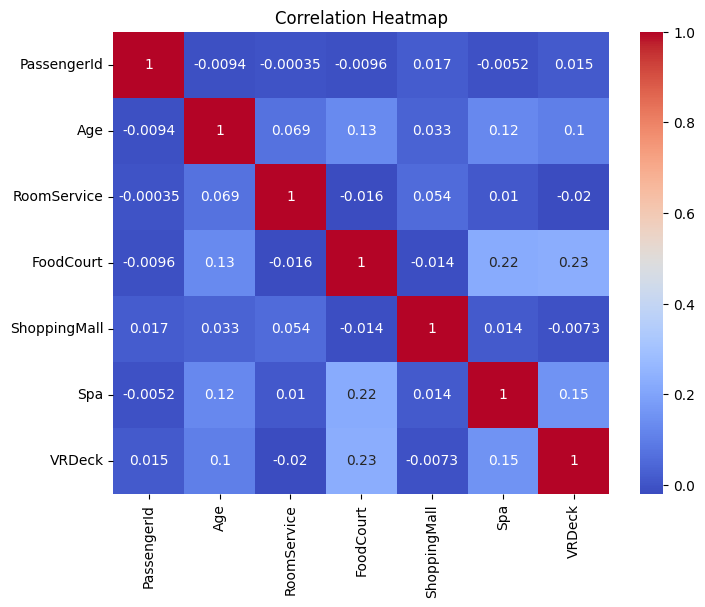

In [23]:
# Examining the correlation matrix for numeric features
import seaborn as sns

# Separating numeric and categorical variables for histogram / value count visualizations
numeric_var = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categoric_var = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP", "Transported"]

corr_df = train_df.drop(categoric_var, axis=1, inplace=False)
corr_mat = corr_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Interpreting Correlation Matrix
* Because none of the features have a very high correlation with each other, each is likely pretty useful to the overall data
* Therefore it is probably not necessary to combine features into a wealth score, we might be losing information

# Another Idea
* I was thinking about how to integrate some data from the PassengerId
* While including group as a categorical variable would be too much, I could compute the group size and use that as a numeric variable, or perhaps even encode it as a categorical variable if group sizes are sufficiently small

Max group size: 8
[1. 1. 2. ... 1. 2. 2.]


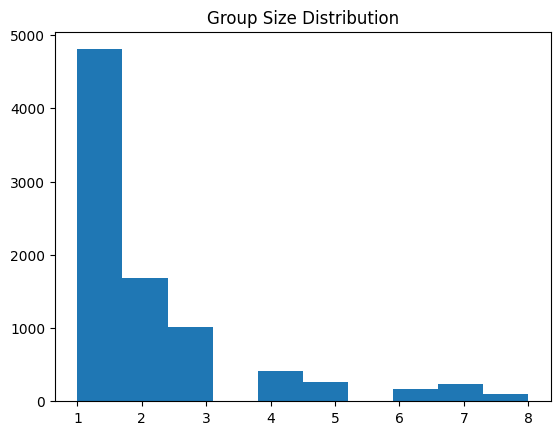

  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported  
0        0.0           0.0     0.0     0.0        False  
1        9.0          25.0   549.0    44.0         True  
2     3576.0           0.0  6715.0    49.0        False  
3     1283.0         371.0  3329.0   193.0        False  
4       70.0         151.0   565.0     2.0         True  


In [24]:
# Computing passenger group sizes
passenger_dict = {}
for i in range(len(train_df)):
    group, num = map(int, train_df["PassengerId"][i].split("_"))
    if group in passenger_dict:
        passenger_dict[group] += 1
    else:
        passenger_dict[group] = 1

print(f"Max group size: {max(passenger_dict.values())}")

# Putting the data into an array
sizes = np.zeros(len(train_df))

for i in range(len(train_df)):
    group, num = map(int, train_df["PassengerId"][i].split("_"))
    sizes[i] = passenger_dict[group]
    
print(sizes)
plt.hist(sizes)
plt.title("Group Size Distribution")
plt.show()

# train_df.insert(0, "GroupSize", sizes)
train_df.drop("PassengerId", axis=1, inplace=True)
print(train_df.head())

In [25]:
# Repeating previous successful analysis steps
deck = [str(train_df["Cabin"][i]).split('/')[0] for i in range(len(train_df))]
side = [str(train_df["Cabin"][i]).split('/')[-1] for i in range(len(train_df))]
train_df.insert(0, "Deck", deck)
train_df.insert(0, "Side", side)
train_df.drop("Cabin", axis=1, inplace=True)

# Dropping NA features from deck and side columns
train_df.dropna(axis=0, how='any', subset=["Deck", "Side"], inplace=True)

# Filling with median for numerical columns
numeric_columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in numeric_columns:
    train_df[col] = train_df[col].fillna(train_df[col].median())

# Standardizing Numeric Columns
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[numeric_columns] = scale.fit_transform(train_df_scaled[numeric_columns])
print(train_df_scaled.head())

  Side Deck HomePlanet CryoSleep  Destination       Age    VIP  RoomService  \
0    P    B     Europa     False  TRAPPIST-1e  0.711945  False    -0.333105   
1    S    F      Earth     False  TRAPPIST-1e -0.334037  False    -0.168073   
2    S    A     Europa     False  TRAPPIST-1e  2.036857   True    -0.268001   
3    S    A     Europa     False  TRAPPIST-1e  0.293552  False    -0.333105   
4    S    F      Earth     False  TRAPPIST-1e -0.891895  False     0.125652   

   FoodCourt  ShoppingMall       Spa    VRDeck  Transported  
0  -0.281027     -0.283579 -0.270626 -0.263003        False  
1  -0.275387     -0.241771  0.217158 -0.224205         True  
2   1.959998     -0.283579  5.695623 -0.219796        False  
3   0.523010      0.336851  2.687176 -0.092818        False  
4  -0.237159     -0.031059  0.231374 -0.261240         True  


In [26]:
# Printing NAN Counts
print(train_df_scaled.isna().sum())
print(f"Length: {len(train_df_scaled)}")

# Dropping NAN values for categorical data
train_df_scaled.dropna(axis=0, how="any", 
                       inplace=True, ignore_index=True)

print(train_df_scaled.isna().sum())
print(f"Length: {len(train_df_scaled)}")

Side              0
Deck              0
HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64
Length: 8693
Side            0
Deck            0
HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
Length: 7913


In [27]:
# Adding dummy variables for the categorical data
encoded_df = pd.get_dummies(train_df_scaled, columns=["Side", "Deck", "HomePlanet", "CryoSleep", "Destination", "VIP"])

In [28]:
# Creating final training and validation sets
from sklearn.model_selection import train_test_split
train_set, validation_set = train_test_split(encoded_df, test_size=0.2)
print(f"Training Set Length: {len(train_set)}")
print(f"Validation Set Length: {len(validation_set)}")

# Creating the X and y arrays for both the training and validation sets
train_X = train_set.drop("Transported", axis=1, inplace=False)
train_y = train_set["Transported"]
validation_X = validation_set.drop("Transported", axis=1, inplace=False)
validation_y = validation_set["Transported"]

Training Set Length: 6330
Validation Set Length: 1583


In [29]:
# Cross validation with the most promising prior model
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svc = SVC()
cvs = cross_val_score(svc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.80884676 0.80331754 0.79304897 0.80015798 0.80647709] with a mean of 0.8023696682464454


In [30]:
# Trying some other models with this new data
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

nb = GaussianNB()
nb.fit(train_X, train_y)
cvs = cross_val_score(nb, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.75829384 0.75197472 0.75829384 0.65323855 0.75750395] with a mean of 0.7358609794628752


In [31]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
cvs = cross_val_score(lr, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.80331754 0.79541864 0.78199052 0.78830964 0.79462875] with a mean of 0.7927330173775671


In [32]:
# Trying the Random Forest Classifier
rfc = RandomForestClassifier()
cvs = cross_val_score(rfc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.78278041 0.80963665 0.77883096 0.77725118 0.79225908] with a mean of 0.7881516587677726


In [33]:
# Trying the K-Nearest Neighbors Classifier
knc = KNeighborsClassifier()
cvs = cross_val_score(knc, train_X, train_y, cv=5)
print(f"Scores of {cvs} with a mean of {np.mean(cvs)}")

Scores of [0.77251185 0.77725118 0.77725118 0.77883096 0.78436019] with a mean of 0.778041074249605


# Hyperparameter Tuning
* Now that we have improved our cross validation score, we should try to optimize the model's hyperparameters
* We use grid search CV to optimize the parameters of our Support Vector Classifier

In [34]:
from sklearn.model_selection import GridSearchCV
params = {"C": [0.1, 1, 10], "gamma": [0.0001, 0.001, 0.01, 0.1, 1]}

model = SVC()
gridSearchCV = GridSearchCV(model, params, cv=5, scoring="accuracy")

gridSearchCV.fit(train_X, train_y)

print(f"Best params: {gridSearchCV.best_params_}")
print(f"Best score: {gridSearchCV.best_score_}")

Best params: {'C': 10, 'gamma': 0.1}
Best score: 0.8034755134281202


In [35]:
params = {"C": [11, 12, 13], "gamma": [0.05, 0.1, 0.15], "shrinking": [False]}
gridSearchCV = GridSearchCV(model, params, cv=5, scoring="accuracy")
gridSearchCV.fit(train_X, train_y)
print(f"Best params: {gridSearchCV.best_params_}")
print(f"Best score: {gridSearchCV.best_score_}")

Best params: {'C': 12, 'gamma': 0.05, 'shrinking': False}
Best score: 0.8042654028436018


# Another Idea
* I was thinking about how to integrate some data from the PassengerId
* While including group as a categorical variable would be too much, I could compute the group size and use that as a numeric variable, or perhaps even encode it as a categorical variable if group sizes are sufficiently small

## Update
* I tried encoding the group size both as a numeric variable and as a categoric variable, and neither helped the analysis. The categorical encoding was slightly better, but still worse than not including it.

In [36]:
# Testing on the validation set with optimal parameters
model = SVC(C=12, gamma=0.1, kernel="rbf", shrinking=False)
model.fit(train_X, train_y)
print(model.score(validation_X, validation_y))

0.7984838913455464


In [37]:
# Final Submission

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
print(train_df.info())

# Dropping features that we don't want to consider right now
# PassengerId might be useful in the future
train_df.drop("Name", axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None


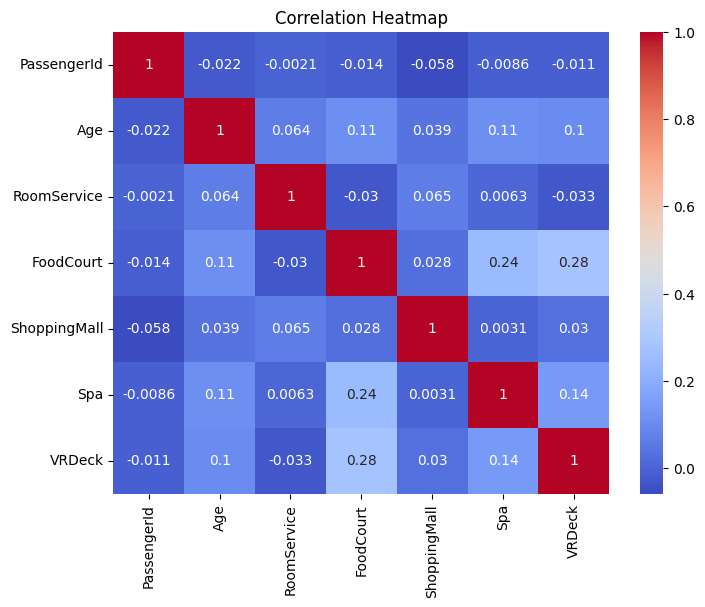

In [38]:
# Examining the correlation matrix for numeric features
import seaborn as sns

# Separating numeric and categorical variables for histogram / value count visualizations
numeric_var = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
categoric_var = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]

corr_df = train_df.drop(categoric_var, axis=1, inplace=False)
corr_mat = corr_df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Max group size: 8
[1. 1. 1. ... 1. 1. 1.]


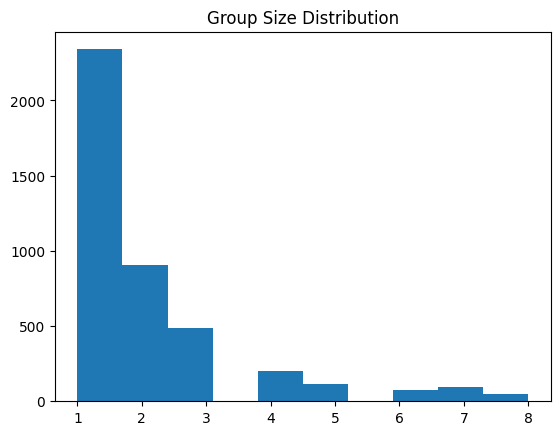

  HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0      Earth      True  G/3/S  TRAPPIST-1e  27.0  False          0.0   
1      Earth     False  F/4/S  TRAPPIST-1e  19.0  False          0.0   
2     Europa      True  C/0/S  55 Cancri e  31.0  False          0.0   
3     Europa     False  C/1/S  TRAPPIST-1e  38.0  False          0.0   
4      Earth     False  F/5/S  TRAPPIST-1e  20.0  False         10.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  
0        0.0           0.0     0.0     0.0  
1        9.0           0.0  2823.0     0.0  
2        0.0           0.0     0.0     0.0  
3     6652.0           0.0   181.0   585.0  
4        0.0         635.0     0.0     0.0  


In [39]:
# Computing passenger group sizes
passenger_dict = {}
for i in range(len(train_df)):
    group, num = map(int, train_df["PassengerId"][i].split("_"))
    if group in passenger_dict:
        passenger_dict[group] += 1
    else:
        passenger_dict[group] = 1

print(f"Max group size: {max(passenger_dict.values())}")

# Putting the data into an array
sizes = np.zeros(len(train_df))

for i in range(len(train_df)):
    group, num = map(int, train_df["PassengerId"][i].split("_"))
    sizes[i] = passenger_dict[group]
    
print(sizes)
plt.hist(sizes)
plt.title("Group Size Distribution")
plt.show()

# train_df.insert(0, "GroupSize", sizes)
train_df.drop("PassengerId", axis=1, inplace=True)
print(train_df.head())

In [40]:
# Repeating previous successful analysis steps
deck = [str(train_df["Cabin"][i]).split('/')[0] for i in range(len(train_df))]
side = [str(train_df["Cabin"][i]).split('/')[-1] for i in range(len(train_df))]
train_df.insert(0, "Deck", deck)
train_df.insert(0, "Side", side)
train_df.drop("Cabin", axis=1, inplace=True)

# Filling with median for numerical columns
numeric_columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
for col in numeric_columns:
    train_df[col] = train_df[col].fillna(train_df[col].median())

# Standardizing Numeric Columns
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[numeric_columns] = scale.fit_transform(train_df_scaled[numeric_columns])
print(train_df_scaled.head())

  Side Deck HomePlanet CryoSleep  Destination       Age    VIP  RoomService  \
0    S    G      Earth      True  TRAPPIST-1e -0.114147  False    -0.357339   
1    S    F      Earth     False  TRAPPIST-1e -0.684313  False    -0.357339   
2    S    C     Europa      True  55 Cancri e  0.170937  False    -0.357339   
3    S    C     Europa     False  TRAPPIST-1e  0.669832  False    -0.357339   
4    S    F      Earth     False  TRAPPIST-1e -0.613042  False    -0.340723   

   FoodCourt  ShoppingMall       Spa    VRDeck  
0  -0.283840     -0.312173 -0.267841 -0.246712  
1  -0.277879     -0.312173  2.287504 -0.246712  
2  -0.283840     -0.312173 -0.267841 -0.246712  
3   4.121518     -0.312173 -0.104002  0.226648  
4  -0.283840      0.832122 -0.267841 -0.246712  


In [41]:
# Printing NAN Counts
print(train_df_scaled.isna().sum())
print(f"Length: {len(train_df_scaled)}")

print(train_df_scaled.isna().sum())
print(f"Length: {len(train_df_scaled)}")

Side             0
Deck             0
HomePlanet      87
CryoSleep       93
Destination     92
Age              0
VIP             93
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
dtype: int64
Length: 4277
Side             0
Deck             0
HomePlanet      87
CryoSleep       93
Destination     92
Age              0
VIP             93
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
dtype: int64
Length: 4277


In [42]:
# Adding dummy variables for the categorical data
encoded_df = pd.get_dummies(train_df_scaled, columns=["Side", "Deck", "HomePlanet", "CryoSleep", "Destination", "VIP"])

In [43]:
print(encoded_df.head())
print(encoded_df.info())

        Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  Side_P  \
0 -0.114147    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   False   
1 -0.684313    -0.357339  -0.277879     -0.312173  2.287504 -0.246712   False   
2  0.170937    -0.357339  -0.283840     -0.312173 -0.267841 -0.246712   False   
3  0.669832    -0.357339   4.121518     -0.312173 -0.104002  0.226648   False   
4 -0.613042    -0.340723  -0.283840      0.832122 -0.267841 -0.246712   False   

   Side_S  Side_nan  Deck_A  ...  HomePlanet_Earth  HomePlanet_Europa  \
0    True     False   False  ...              True              False   
1    True     False   False  ...              True              False   
2    True     False   False  ...             False               True   
3    True     False   False  ...             False               True   
4    True     False   False  ...              True              False   

   HomePlanet_Mars  CryoSleep_False  CryoSleep_True  Destination_55 Cancri

In [44]:
# Evaluation with the final model

prediction_arr = model.predict(encoded_df)
prediction = pd.DataFrame()
prediction.insert(0, "Transported", prediction_arr)
original = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
prediction.insert(0, "PassengerId", original["PassengerId"])
print(prediction.head())

  PassengerId  Transported
0     0013_01         True
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01         True


In [45]:
# Saving
print(f'Length of final data, should be 4277: {len(prediction)}')
prediction.to_csv("submission.csv", index=False)

Length of final data, should be 4277: 4277


In [46]:
# Checking that submission matches the expected output
expected = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
print(expected.head())
print(expected.info())

  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01        False
3     0021_01        False
4     0023_01        False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB
None
